## **Use Case E - Neural Network for Inherent Optical Properties**
In this notebook, we demonstrate how to leverage hyperspectral simulations of remote sensing reflectance based on the bio-optical model by Bi et al. (2023) and the simulation framework by König et al. (2023), to predict Inherent Optical Properties (IOPs) using a Neural Network. Specifically, we target the prediction of total phytoplankton absorption (aph​), gelbstoff absorption (adg​), non-algal particle absorption (anap​), and particle backscattering (bbp​) at 443 nm.  
Furthermore, we provide a complete workflow for integrating your PyTorch-trained model directly into the Case 2 Regional Coast Colour (C2RCC) processor within the ESA SNAP (Sentinel Application Platform) toolbox.

C2RCC is a widely adopted processor for estimating water quality parameters (such as Chl-a and TSM) in optically complex coastal and inland waters. It functions by using neural networks to invert the radiative transfer signal, correcting for atmospheric and water-leaving radiance effects. However, the performance of the default C2RCC neural networks is limited by the scope of their original training data. Neural Networks are fundamentally mathematical interpolators, they excel at making predictions when the input data falls within the distribution they were trained on. Conversely, they are often poor extrapolators when applied to water types that lie outside their training range (e.g., extremely turbid lakes or specific regional blooms), their accuracy degrades significantly.

### **Contents**
This notebook is structured to guide you through:
1. **Data Retrieval**: Downloading the required datasets, including HyperspectralSimForS2-waters from the Earth Observation Training Data Lab (EO-TDL) and a reference Sentinel-2 scene from the Copernicus Data Space Ecosystem (CDSE).
2. **Data Preparation**: Pre-processing the simulation data for ingestion into the model.
3. **Model Training**: Implementing and training a Multi-Layer Perceptron (MLP) using PyTorch.
4. **Inference & Validation**: Exporting the trained PyTorch model to the SNAP-compatible .net format, running the C2RCC processor with the custom network on a Sentinel-2 scene, and comparing the results against the standard C2RCC output.

### Dependencies
The notebook uses the EO-TDL environment, which includes standard machine learning and geospatial libraries such as `numpy`, `pandas`, `xarray`, and `pytorch`. To complete the final inference section (Step 4), ESA SNAP must be installed on your local machine and accessible via your system environment path.
* **Download SNAP**: You can find the latest installers for SNAP and the various Toolboxes here:  
 step.esa.int/main/download/snap-download/

In [12]:
# Standard library imports
import os
import sys
import subprocess
from pathlib import Path
import pathlib
import copy

# Third-party imports
import numpy as np
import pandas as pd
import xarray as xr
import requests
import geopandas as gpd
from shapely.geometry import shape
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from eotdl.datasets import stage_dataset_file


# Local / project imports
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.append(str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

from scripts.helper import (
    normalize_dataframe,
    model_to_net,
)

# Because we like dark mode
style.use('dark_background')

## Dataset Retrieval
This example relies on two data sources, simulated hyperspectral data for training the neural network, and a real-world Sentinel-2 scene for inference and validation.
We acquire the training dataset from the Earth Observation Training Data Lab (EO-TDL) using the eotdl Python client (see 01_exploring_and_staging for library basics).
The specific dataset used is HyperspectralSimForS2-waters. It consists of a catalog (.parquet) pointing to paired NetCDF resources:

* **Target (Y)**: A NetCDF file containing the Inherent Optical Properties (IOPs).

* **Input (X)**: A NetCDF file containing the simulated hyperspectral Remote Sensing Reflectance (Rrs​).

The code below downloads the dataset and parses the catalog to locate the necessary .nc files.

To test our model, we also retrieve a specific Sentinel-2 Level-1C (Top-of-Atmosphere) scene via the Copernicus Data Space Ecosystem (CDSE).  

Prerequisites: You must have a registered CDSE account, and the code expects your credentials (CDSE_USERNAME, CDSE_PASSWORD) to be stored in a .env file.

 * Register for a CDSE account here (https://documentation.dataspace.copernicus.eu/Registration.html).  

We utilize the CDSE OData API to filter for a scene meeting the following criteria:
* **Region of Interest**: Intersects a bounding box around the Volga River mouth at the Caspian Sea. 
* **Product Type**: S2MSI1C (Sentinel-2 MultiSpectral Instrument, Level-1C). 
* **Cloud Cover**: Exactly 0.0 (Cloud-free). 
* **Selection Strategy**: The query returns the top 20 candidates. 

We then calculate the area of the GeoFootprint for each candidate and select the scene with the largest surface area. This ensures we download a complete tile rather than a partial swath or edge artifact. Finally, we download the .zip product and plot the footprints to visually verify our selection.

In [13]:
!eotdl datasets get HyperspectralSimForS2-waters -p data -f

df = pd.read_parquet('data/HyperspectralSimForS2-waters/catalog.v1.parquet')

for _, row in df.iterrows():
    for k, v in row['assets'].items():
        if pathlib.Path(v['href']).suffix in ['.nc']:
            path = stage_dataset_file(v['href'], "data")
            print(path)

Data available at data/HyperspectralSimForS2-waters
data/C2RCC-water-training-hyperspectral-iop.nc
data/C2RCC-water-training-hyperspectral-sim.nc


Downloaded: S2A_MSIL1C_20170618T073611_N0500_R092_T39TUL_20231016T130132.SAFE.zip


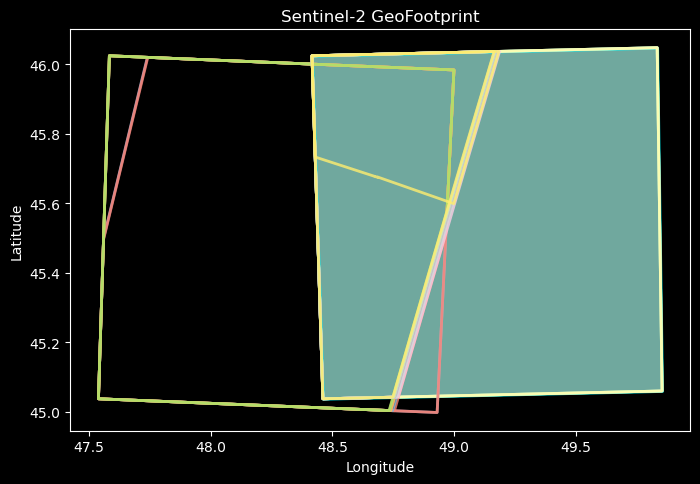

In [14]:
# CDSE login
load_dotenv(dotenv_path=PROJECT_ROOT / '.env')

USERNAME = os.getenv('CDSE_USERNAME')
PASSWORD = os.getenv('CDSE_PASSWORD')

def get_token(username: str, password: str) -> str:
    """Request Copernicus Dataspace OAuth token."""
    url = (
        "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/"
        "protocol/openid-connect/token"
    )

    payload = {
        "client_id": "cdse-public",
        "grant_type": "password",
        "username": username,
        "password": password,
    }

    r = requests.post(url, data=payload)
    r.raise_for_status()

    token_json = r.json()
    if "access_token" not in token_json:
        raise RuntimeError("Authentication failed — no token returned.")

    return token_json["access_token"]

# Get OAuth2 token
token = get_token(USERNAME, PASSWORD)

# Search for Sentinel-2 L1C products with 0% cloud cover over a bounding box
bbox = [48.757324,45.656288,49.328613,45.890008] 

polygon = (
    f"{bbox[0]} {bbox[1]},"
    f"{bbox[2]} {bbox[1]},"
    f"{bbox[2]} {bbox[3]},"
    f"{bbox[0]} {bbox[3]},"
    f"{bbox[0]} {bbox[1]}"
)

odata_url = (
    "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
    "$filter="
    f"OData.CSC.Intersects(area=geography'SRID=4326;POLYGON(({polygon}))')"
    " and Collection/Name eq 'SENTINEL-2'"
    " and Attributes/OData.CSC.DoubleAttribute/any(att: att/Name eq 'cloudCover' and att/Value le 0.0)"
    " and Attributes/OData.CSC.StringAttribute/any(att: att/Name eq 'productType' and att/Value eq 'S2MSI1C')"
    "&$top=20"
)

resp = requests.get(odata_url)
resp.raise_for_status()
json_data = resp.json()

if "value" not in json_data or len(json_data["value"]) == 0:
    raise RuntimeError("No Sentinel-2 L1C scenes found for your query!")

df = pd.DataFrame(json_data["value"])

# Process GeoFootprint and find the largest footprint
df["geometry"] = df["GeoFootprint"].apply(shape)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf_area = gdf.to_crs("EPSG:6933")
gdf["footprint_area_m2"] = gdf_area.area

gdf.sort_values(by="footprint_area_m2", ascending=False, inplace=True)

product_id = gdf.iloc[0]["Id"]
product_name = gdf.iloc[0]["Name"]

download_url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

# Download SAFE ZIP using the token
headers = {"Authorization": f"Bearer {token}"}

with requests.get(download_url, stream=True, headers=headers) as r:
    r.raise_for_status()
    with open(f"data/{product_name}.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            f.write(chunk)

print("Downloaded:", f"{product_name}.zip")

# Plot GeoFootprints
ax = gdf.iloc[[0]].plot(cmap ='Set3', linewidth=2, figsize=(8, 8), alpha=0.8, edgecolor='cyan')
ax = gdf.plot(cmap='Set3', facecolor="none", linewidth=2, ax=ax, alpha=0.8)
plt.title("Sentinel-2 GeoFootprint")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Data Preparation
We begin by defining the necessary file paths for the input data and the intermediate/final output files. This workflow relies on XML Graph files to chain specific processing steps within the ESA SNAP Command Line Interface (GPT).

#### Cleaning and Transformation

The simulated dataset contains hyperspectral data, but we must adapt it to match the specific input requirements of the C2RCC neural network architecture and the Sentinel-2 spectral resolution.

* **Outlier Removal**: We apply a 0.99 quantile filter to the dataset. A boolean mask is created to identify samples where any IOP target variable exceeds its 99th percentile. This mask is applied to both the inputs (Rrs​) and targets (IOPs) to ensure we train on a non-extreme distribution.

* **Spectral Subsetting**: We select only the first 6 bands of the hyperspectral simulation (wavelength=slice(0, 6)). This roughly aligns the input dimensionality with the visible and near-infrared bands of Sentinel-2 used by standard C2RCC.

* **Unit Conversion**: The simulation provides Remote Sensing Reflectance (Rrs​). However, the C2RCC network expects Water Leaving Reflectance, so we multiply the simulation values by π.

* **Log Transformation**: A natural logarithm transformation (ln(x+10−12)) is applied to both inputs and targets. This compresses the dynamic range of the optical data and is a standard requirement for C2RCC-compatible networks.

#### Feature Engineering & Alignment

There are structural deviations between our simulation data and the topology expected by the standard C2RCC neural network (rw_to_iop). We must align our features to match this expected structure:

* **Auxiliary Inputs (X)**: The network requires environmental variables. We extract randomly generated sun_zenith, view_zenith, view_azimuth, temperature, and salinity from the simulation metadata to serve as input features alongside the reflectance.

* **Dummy Target (Y)**: Our simulation targets four IOPs: apig, adet, agelb, and bpart. However, the standard C2RCC architecture expects a fifth output: bwit (whitening particles). We generate a dummy variable (bwit_dummy) with a constant value (e.g., -1) to satisfy this requirement without affecting our specific predictions.

#### Normalization

Neural networks using Sigmoid activation functions require input data scaled between [0,1].

* We calculate the global Min/Max values for every feature. These dictionaries (X_params, Y_params) serve for normalizing the data for training, and defining the scaling factors in the exported .net file later.

* The normalized data is split into Training (80%) and Validation (20%) sets.

Finally, we convert the processed numpy arrays into PyTorch Tensors, move them to the computed device (GPU/CPU), and wrap them in DataLoaders to handle batching during the training loop.

In [24]:
# Input files
s2_safe = Path(f'data/{product_name}.zip')
rrs_training = Path(r'data\C2RCC-water-training-hyperspectral-sim.nc')
iop_target = Path(r'data\C2RCC-water-training-hyperspectral-iop.nc')

# Output files
product = gdf.iloc[0]["Name"].split(".")[0]
nets_dir = Path('nets')
s2_resampled_out = Path(f'data/{product}_resampled.nc') 
s2_mndwi_out = Path(f'data/{product}_resampled_mndwi.nc')
s2_c2rcc_out = Path(f'data/{product}_resampled_c2rcc.nc')
s2_custom_c2rcc_out = Path(f'data/{product}_resampled_custom_c2rcc2.nc')

# XML graph files
xml_resample_graph = Path('xml/S2-resample.xml')
xml_mndwi_graph = Path('xml/S2-MNDWI.xml')
xml_c2rcc_graph = Path('xml/S2-C2RCC.xml')

In [16]:
# Load Data
ds_sim = xr.open_dataset(rrs_training)
ds_iop = xr.open_dataset(iop_target)

quant = 0.99
mask = True

for var in list(ds_iop.data_vars):
    q = ds_iop[var].quantile(quant)
    mask = mask & (ds_iop[var] <= q)

mask_bool = mask.values

def apply_mask(ds, mask_bool):
    mask_dims = [dim for dim, size in ds.sizes.items() if size == len(mask_bool)]
    return ds.isel({dim: mask_bool for dim in mask_dims})

ds_iop = apply_mask(ds_iop, mask_bool)
ds_sim = apply_mask(ds_sim, mask_bool)

ds_sim = ds_sim.isel(wavelength=slice(0, 6))
ds_sim['simulation'] = ds_sim['simulation'] * np.pi

ds_sim['simulation'] = np.log(ds_sim['simulation'] + 1e-12)
ds_iop = np.log(ds_iop + 1e-12)

df_aux = ds_sim[['sun_zenith', 'view_zenith', 'view_azimuth',
                 'temperature', 'salinity']].to_dataframe().reset_index(drop=True)

df_rrs = ds_sim.simulation.transpose('reflectance', 'wavelength').to_pandas()
df_rrs.columns = [str(w) for w in ds_sim.wavelength.values]

df_iop = ds_iop[['apig','adet','agelb','bpart']].to_dataframe().reset_index(drop=True)
df_iop['bwit_dummy'] = -1

X_params = {
    'sun_zenith':    (df_aux['sun_zenith'].min(), df_aux['sun_zenith'].max()),
    'view_zenith':   (df_aux['view_zenith'].min(), df_aux['view_zenith'].max()),
    'view_azimuth':  (df_aux['view_azimuth'].min(), df_aux['view_azimuth'].max()),
    'temperature':   (df_aux['temperature'].min(), df_aux['temperature'].max()),
    'salinity':      (df_aux['salinity'].min(), df_aux['salinity'].max()),
}

for w in df_rrs.columns:
    X_params[w] = (df_rrs[w].min(), df_rrs[w].max())

Y_params = {
    'apig':        (df_iop['apig'].min(), df_iop['apig'].max()),
    'adet':        (df_iop['adet'].min(), df_iop['adet'].max()),
    'agelb':       (df_iop['agelb'].min(), df_iop['agelb'].max()),
    'bpart':       (df_iop['bpart'].min(), df_iop['bpart'].max()),
    'bwit_dummy':  (-6.908, 4.087)
}

X_df = pd.concat([df_aux, df_rrs], axis=1)

X = normalize_dataframe(X_df, X_params).values
Y = normalize_dataframe(df_iop, Y_params).values


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(Y_val, dtype=torch.float32).to(device)

# Create DataLoaders for batching
train_dataset = TensorDataset(X_train_t, Y_train_t)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

Using device: cpu


## Model Training
In this section, we define and train the neural network. The architecture and training strategy are designed to replicate the structure expected by the C2RCC processor while utilizing modern PyTorch best practices.
We implement a Multi-Layer Perceptron (MLP), where the network topolgy consists of an input layer, four hidden layers and an output layer.
* **Topology**: Input -> 23 -> 41 -> 59 -> 43 -> Output.

We use the Sigmoid activation function for all layers. This restricts the output of each neuron to the (0,1) range, which is a requirement for standard C2RCC network definitions and helps maintain stability given our normalized inputs. 

Instead of the standard Mean Squared Error (MSE), we employ a Quantile Loss function with q=0.5. Mathematically, minimizing Quantile Loss at q=0.5 is equivalent to minimizing the Mean Absolute Error (MAE). This approach prioritizes the median of the distribution and is generally more robust to outliers in the simulation data than MSE.

Lastly, we use Adam with an initial learning rate of 1e−4, and a ReduceLROnPlateau scheduler monitors the validation loss. If the loss stagnates for 10 epochs, the learning rate is reduced by 50% to help the model settle into a local minimum.  We track the validation loss at every epoch. If the model fails to improve for 5 consecutive epochs (patience=5), training is halted automatically.

Epoch 1/100 - Loss: 0.0597 - Val Loss: 0.0421
Epoch 2/100 - Loss: 0.0417 - Val Loss: 0.0416
Epoch 3/100 - Loss: 0.0416 - Val Loss: 0.0416
Epoch 4/100 - Loss: 0.0416 - Val Loss: 0.0416
Epoch 5/100 - Loss: 0.0416 - Val Loss: 0.0415
Epoch 6/100 - Loss: 0.0415 - Val Loss: 0.0414
Epoch 7/100 - Loss: 0.0412 - Val Loss: 0.0408
Epoch 8/100 - Loss: 0.0388 - Val Loss: 0.0334
Epoch 9/100 - Loss: 0.0247 - Val Loss: 0.0207
Epoch 10/100 - Loss: 0.0198 - Val Loss: 0.0190
Epoch 11/100 - Loss: 0.0187 - Val Loss: 0.0183
Epoch 12/100 - Loss: 0.0182 - Val Loss: 0.0180
Epoch 13/100 - Loss: 0.0180 - Val Loss: 0.0179
Epoch 14/100 - Loss: 0.0179 - Val Loss: 0.0177
Epoch 15/100 - Loss: 0.0178 - Val Loss: 0.0176
Epoch 16/100 - Loss: 0.0176 - Val Loss: 0.0175
Epoch 17/100 - Loss: 0.0175 - Val Loss: 0.0174
Epoch 18/100 - Loss: 0.0174 - Val Loss: 0.0173
Epoch 19/100 - Loss: 0.0173 - Val Loss: 0.0172
Epoch 20/100 - Loss: 0.0172 - Val Loss: 0.0171
Epoch 21/100 - Loss: 0.0172 - Val Loss: 0.0171
Epoch 22/100 - Loss: 0

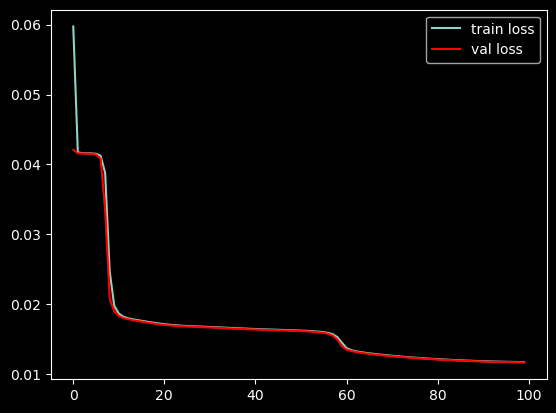

In [17]:
# Model Definition
class QuantileModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuantileModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 23),
            nn.Sigmoid(),
            nn.Linear(23, 41),
            nn.Sigmoid(),
            nn.Linear(41, 59),
            nn.Sigmoid(),
            nn.Linear(59, 43),
            nn.Sigmoid(),
            nn.Linear(43, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
model = QuantileModel(input_dim, output_dim).to(device)

# Quantile Loss Function
def quantile_loss(y_pred, y_true, q=0.5):
    e = y_true - y_pred
    return torch.mean(torch.max(q*e, (q-1)*e))

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6
)

# Training Loop with Early Stopping Logic
epochs = 100
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_model_weights = None

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()           # Reset gradients
        outputs = model(batch_X)        # Forward pass
        loss = quantile_loss(outputs, batch_Y, q=0.5)
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_out = model(X_val_t)
        v_loss = quantile_loss(val_out, y_val_t, q=0.5)
        val_loss = v_loss.item()
    
    val_loss_history.append(val_loss)
    
    # Update Scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_weights) # Restore best weights
            break

# Restore best weights if loop finished without breaking
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

# Plotting
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss', color='red')
plt.legend()
plt.show()

## Inference & Validation
Now that we have a trained PyTorch model, we will validate it by integrating it into the actual C2RCC processor. This involves a multi-step process:

1. Resampling the Sentinel-2 scene to a common resolution (required for C2RCC).

2. Downloading the original C2RCC neural network files to serve as a baseline.

3. Running C2RCC with the default networks (Reference).

4. Creating a Water Mask using MNDWI to mask water pixels.

5. Exporting our trained PyTorch model to the SNAP format.

6. Running C2RCC with our custom network.

7. Comparing the results visually and statistically.

### 1. Resample Sentinel-2 Data

C2RCC requires all bands to be at the same spatial resolution. We use SNAP's Graph Processing Tool (gpt) to resample the Sentinel-2 product and visualize the RGB image.

Executing SNAP GPT: S2 Resampling
Resampling completed.


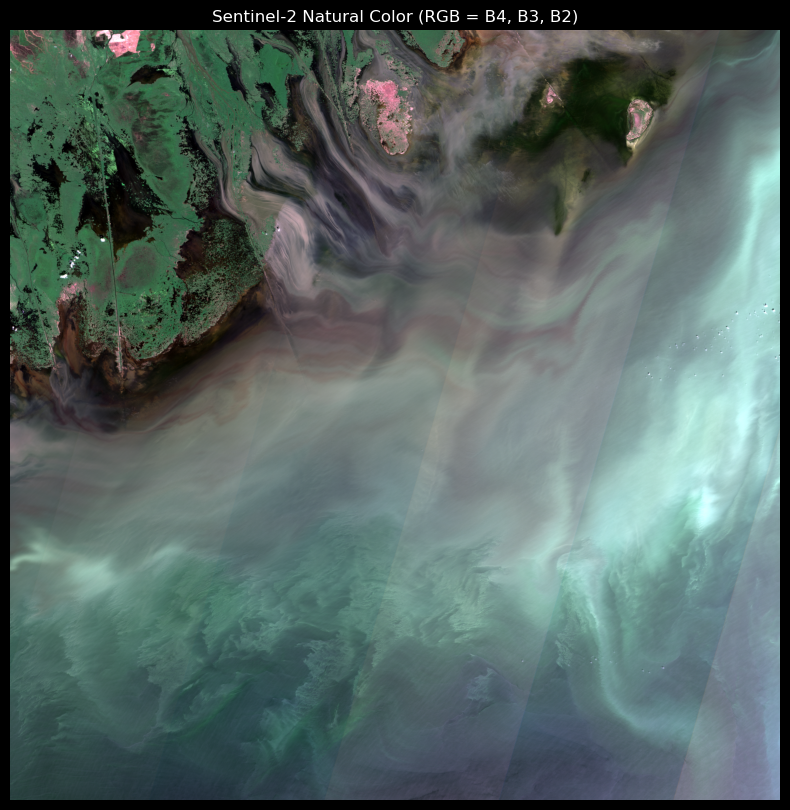

In [27]:
# Resample Sentinel-2 scene using SNAP GPT
cmd = [
    'gpt',
    '-J-Xmx8G',
    str(xml_resample_graph),
    f'-Pinput={s2_safe}',
    f'-Poutput={s2_resampled_out}',
    '-q', '8000',
]

print('Executing SNAP GPT: S2 Resampling')
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print('Resampling completed.')
else:
    print('Resampling failed:', result.stderr)

# Visualize resampled Sentinel-2 data
ds = xr.open_dataset(s2_resampled_out)

figsize=(10, 10)
percentile=(0.1, 99.9)

# Extract RGB bands and convert to numpy
r = ds['B4'].values.astype(np.float32)
g = ds['B3'].values.astype(np.float32)
b = ds['B2'].values.astype(np.float32)

# Stack into RGB array
rgb = np.stack([r, g, b], axis=-1)

# Handle possible scaling 
if np.nanmax(rgb) > 1.5:  
    rgb /= 10000.0

# Clip invalid values
rgb = np.clip(rgb, 0, 1)

rgb_stretched = np.zeros_like(rgb)

for i in range(3):
    p_low, p_high = np.nanpercentile(rgb[..., i], percentile)
    rgb_stretched[..., i] = np.clip((rgb[..., i] - p_low) / (p_high - p_low), 0, 1)
rgb = rgb_stretched

# Plot
plt.figure(figsize=figsize)
plt.imshow(rgb)
plt.axis('off')
plt.title('Sentinel-2 Natural Color (RGB = B4, B3, B2)')
plt.show()

### 2. Retrieve Original C2RCC Networks

To benchmark our results, we need the original neural networks used by C2RCC. We download them directly from the SNAP GitHub repository.

In [28]:
def download_github_directory(api_url, local_dir):
    response = requests.get(api_url)
    if response.status_code != 200:
        raise RuntimeError(f'GitHub API request failed: {response.status_code}')
    
    items = response.json()
    for item in items:
        if item['type'] == 'file':
            # Download file
            download_url = item['download_url']
            local_file = local_dir / item['name']
            print(f'Downloading {download_url} -> {local_file}')
            r = requests.get(download_url)
            r.raise_for_status()
            with open(local_file, 'wb') as f:
                f.write(r.content)
        elif item['type'] == 'dir':
            # Recurse into subfolder
            subfolder = local_dir / item['name']
            subfolder.mkdir(exist_ok=True)
            download_github_directory(item['url'], subfolder)
            
api_url = (
    'https://api.github.com/repos/senbox-org/optical-toolbox/'
    'contents/opttbx-c2rcc/src/main/resources/auxdata/nets/msi/std_s2_20160502'
)


print('Downloading C2RCC Neural Network .nets files')
download_github_directory(api_url, nets_dir)
print('Download completed.')


Download completed.


### 3. Run Reference C2RCC (Default Nets)

We run the standard C2RCC processor on the resampled scene. This provides the baseline for comparison.

In [29]:
cmd = [
    'gpt',
    '-J-Xmx8G',
    str(xml_c2rcc_graph),
    f'-Pinput={s2_resampled_out}',
    f'-Poutput={s2_c2rcc_out}',
    f'-PNNpath={nets_dir}',
    '-q', '8000',
]

print('Executing SNAP GPT: C2RCC (original nets)')
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print('C2RCC completed.')
else:
    print('C2RCC failed:', result.stderr)

ds_c2rcc = xr.open_dataset(s2_c2rcc_out)


Executing SNAP GPT: C2RCC (original nets)
C2RCC completed.


### 4. Generate Water Mask (MNDWI)

We compute the Modified Normalized Difference Water Index (MNDWI) and create a binary mask for comparing the reference and our output only at water pixels.

Executing SNAP GPT: MNDWI
MNDWI completed.


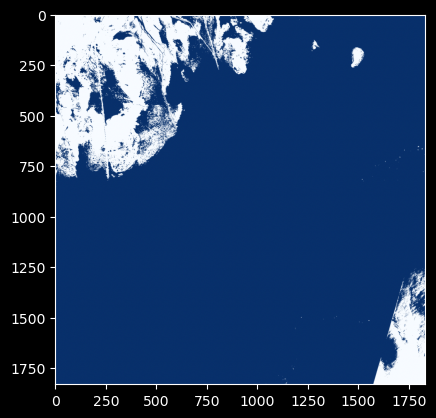

In [30]:
cmd = [
    'gpt',
    '-J-Xmx8G',
    str(xml_mndwi_graph),
    f'-Pinput={s2_resampled_out}',
    f'-Poutput={s2_mndwi_out}',
    '-q', '8000',
]

print('Executing SNAP GPT: MNDWI')
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print('MNDWI completed.')
else:
    print('MNDWI failed:', result.stderr)

ds_mndwi = xr.open_dataset(s2_mndwi_out)

mndwi_mask = ds_mndwi[f'{product}_resampled_mndwi'].values > 0.5
plt.imshow(mndwi_mask, cmap='Blues')

### 5. Export Custom PyTorch Model

We now use our helper function to export the trained PyTorch model into the ASCII .net format required by SNAP. We place this file into the nets directory where C2RCC expects it.

In [31]:
model_to_net(
    model=model,
    input_config=X_params,
    output_config=Y_params,
    input_names=X_df.columns.tolist(),
    output_names=df_iop.columns.tolist(),
    filename=Path("nets/rw_iop/97x77x37_17515.9.net")
)


Successfully exported PyTorch model to: nets\rw_iop\97x77x37_17515.9.net


### 6. Run Custom C2RCC

We execute C2RCC again, but this time with our custom-trained network located in nets/rw_iop.

In [32]:
cmd = [
    'gpt',
    '-J-Xmx8G',
    str(xml_c2rcc_graph),
    f'-Pinput={s2_resampled_out}',
    f'-Poutput={s2_custom_c2rcc_out}',
    f'-PNNpath={nets_dir}',
    '-q', '8000',
]

print('Executing SNAP GPT: C2RCC (altered nets)')
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print('Custom C2RCC completed.')
else:
    print('Custom C2RCC failed:', result.stderr)

ds_custom_c2rcc = xr.open_dataset(s2_custom_c2rcc_out)

Executing SNAP GPT: C2RCC (altered nets)
Custom C2RCC completed.


### 7. Comparison: Spatial Distribution

We visually compare the spatial distribution of the IOPs generated by the standard C2RCC versus our custom model.

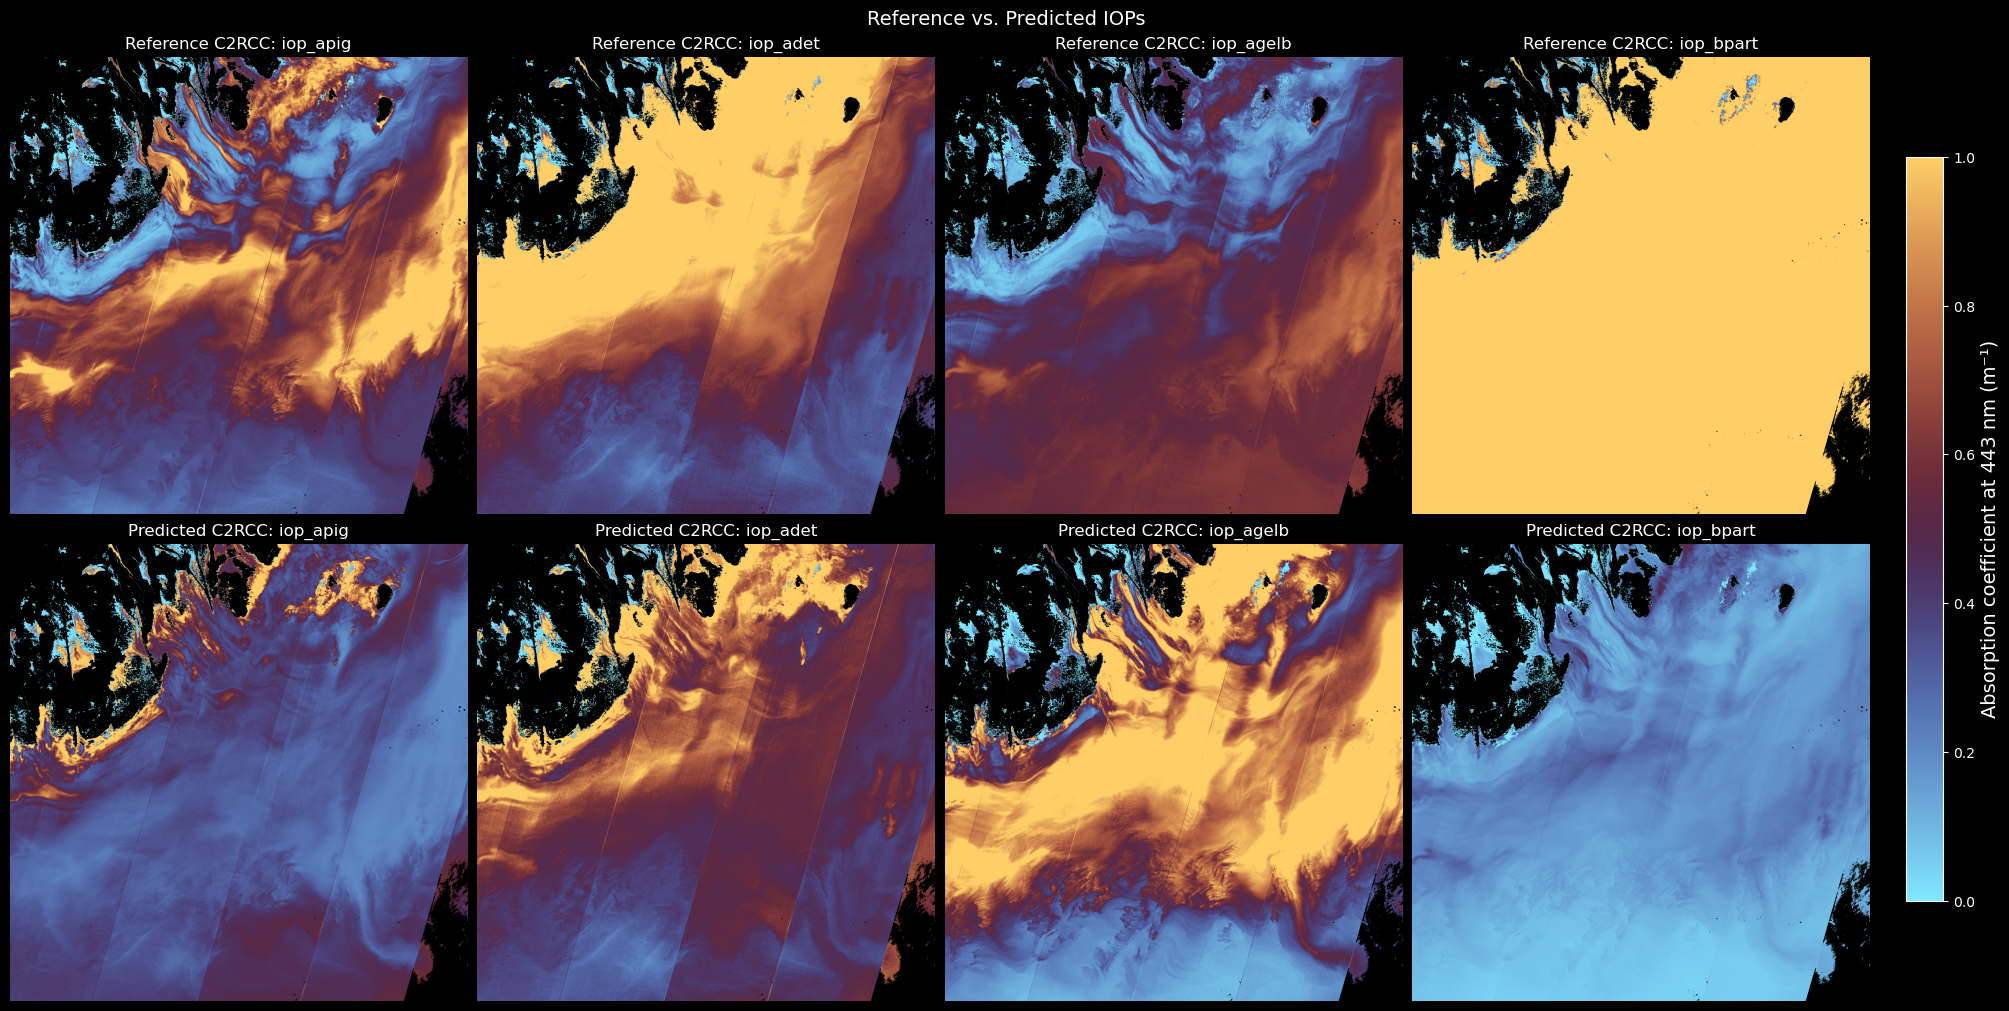

In [33]:
iop_names = ['iop_apig', 'iop_adet', 'iop_agelb', 'iop_bpart']

# --- Create figure with 2 rows (predictions + reference) ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10),constrained_layout=True)

for i, iop_name in enumerate(iop_names):
    # --- Masked model prediction ---
    pred_iop = np.where(mndwi_mask, ds_custom_c2rcc[iop_name].values, np.nan)
    ref_iop = np.where(mndwi_mask, ds_c2rcc[iop_name].values, np.nan)

    # --- Top row: Model Reference ---
    im_pred = axes[0, i].imshow(ref_iop, cmap="managua_r", vmin=0, vmax=1)
    axes[0,i].set_title(f"Reference C2RCC: {iop_name}")


    # --- Bottom row: Prediction data ---
    im_ref = axes[1, i].imshow(pred_iop, cmap="managua_r", vmin=0, vmax=1)
    axes[1,i].set_title(f"Predicted C2RCC: {iop_name}")


    axes[0, i].axis('off')
    axes[1, i].axis('off')

cbar = fig.colorbar(im_ref, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02, )
cbar.set_label("Absorption coefficient at 443 nm (m⁻¹)", fontsize=14)

fig.suptitle('Reference vs. Predicted IOPs', fontsize=14)

plt.show()

### 8. Comparison: Histograms

Finally, we compare the statistical distributions (histograms) of the IOPs.

* Top Row: Compares the Reference C2RCC output against our Training Target Distribution. This reveals if the standard C2RCC is predicting values similar to our simulated bio-optical model.

* Bottom Row: Compares the Reference C2RCC against our Custom Prediction. This highlights the shift in predictions caused by training on our specific dataset.

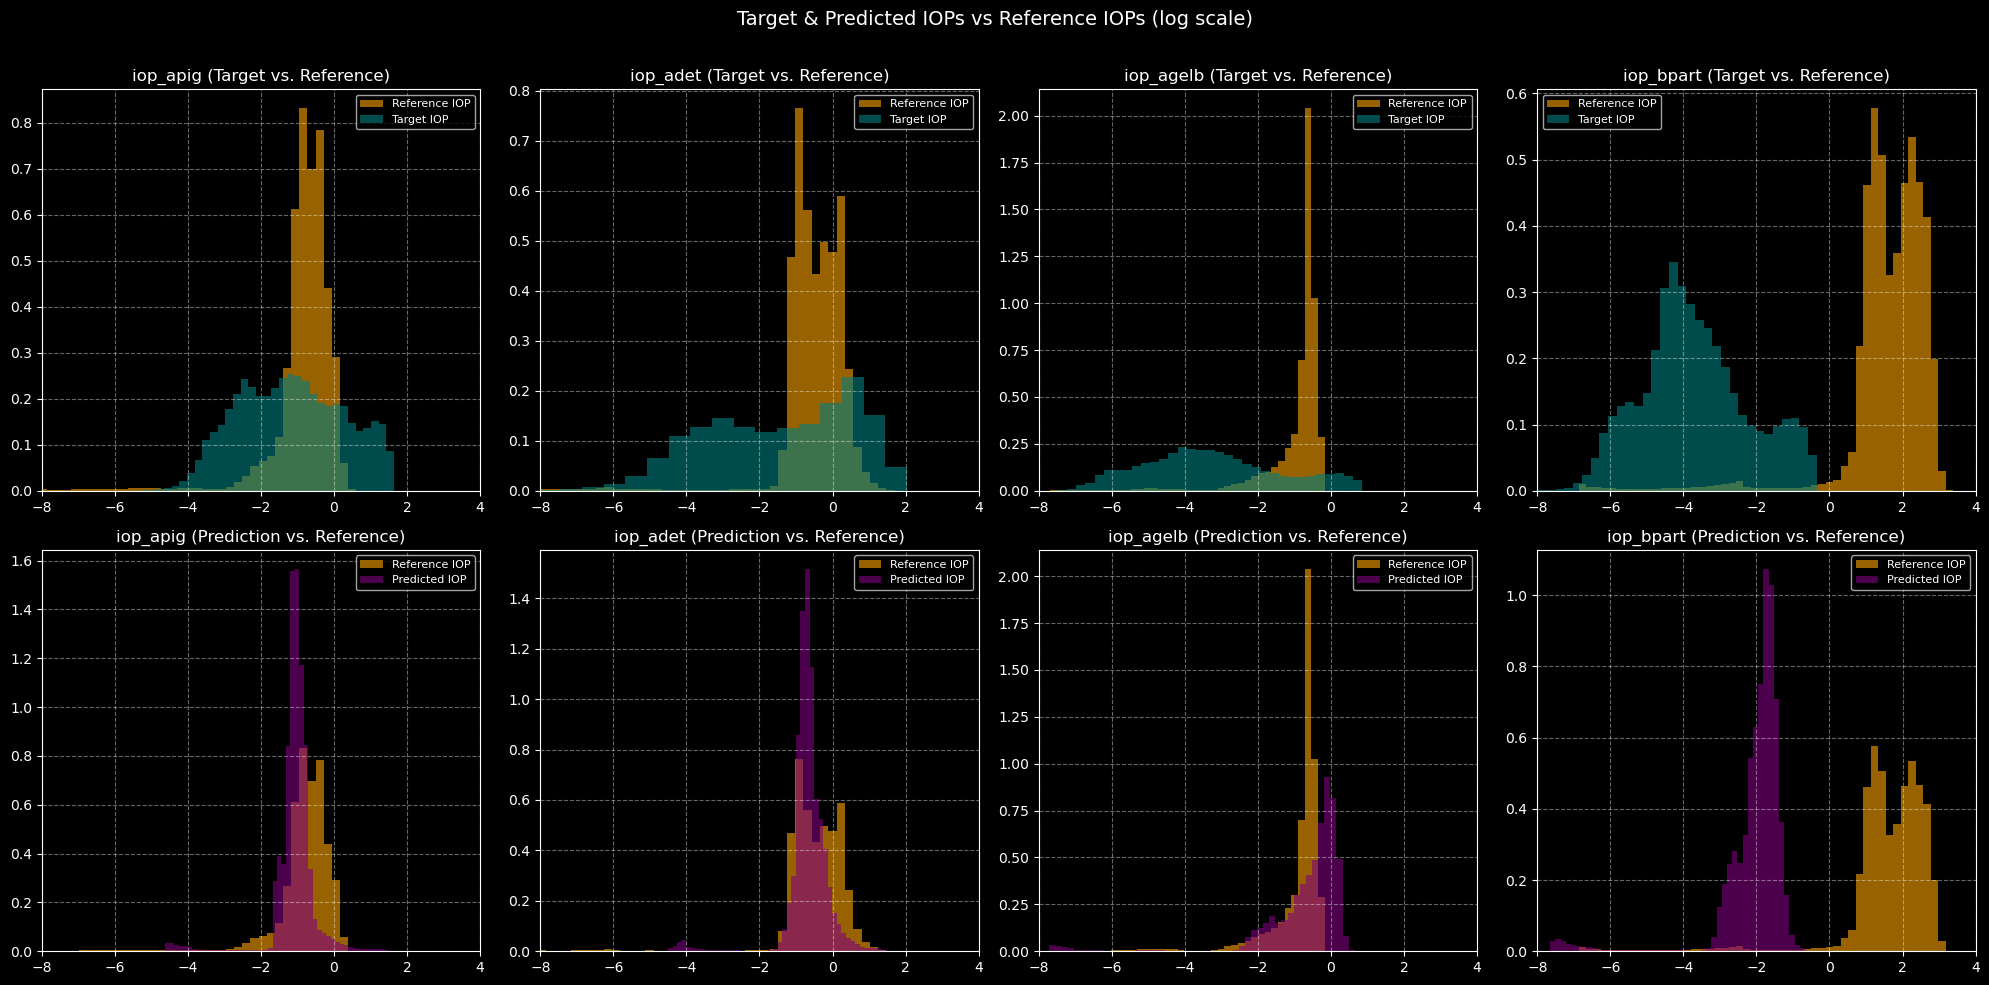

In [34]:
# --- Create figure for histograms ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  

df_iop_values = df_iop.values
for i, iop_name in enumerate(iop_names):   
        # Flatten and mask non-water pixels
        target_iop = df_iop_values[:, i].flatten()
        pred_iop = np.where(mndwi_mask, ds_custom_c2rcc[iop_name].values, np.nan).flatten()
        ref_iop = np.where(mndwi_mask, ds_c2rcc[iop_name].values, np.nan).flatten()

        # --- Row 1: Reference vs Target ---
        ax1 = axes[0, i]
        ax1.hist(np.log(ref_iop), bins=50, alpha=0.6, label='Reference IOP', color='orange', density=True)
        ax1.hist(target_iop, bins=50, alpha=0.6, label='Target IOP', color='teal', density=True)
        ax1.set_title(f'{iop_name} (Target vs. Reference)')
        ax1.grid(True, linestyle='--', alpha=0.4)
        ax1.legend(fontsize=8)
        ax1.set_xlim(-8,4)

        # --- Row 2: Reference vs Predicted ---
        ax2 = axes[1, i]
        ax2.hist(np.log(ref_iop), bins=50, alpha=0.6, label='Reference IOP', color='orange', density=True)
        ax2.hist(np.log(pred_iop), bins=50, alpha=0.6, label='Predicted IOP', color='purple', density=True)
        ax2.set_title(f'{iop_name} (Prediction vs. Reference)')
        ax2.grid(True, linestyle='--', alpha=0.4)
        ax2.legend(fontsize=8)
        ax2.set_xlim(-8,4)


fig.suptitle('Target & Predicted IOPs vs Reference IOPs (log scale)', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
